In [9]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def f(x):
    return 3*x**2-5*x-7

In [17]:
f(3.0)

5.0

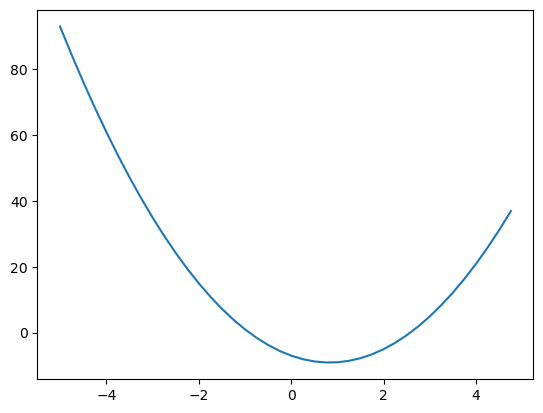

In [24]:
xs=np.arange(-5.0,5.0,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [58]:
h=0.00000001
x=0.8335
(f(x+h)-f(x))/h

0.001000088900582341

In [64]:
h=0.00001

#inputs
a=2.0
b=-3.0
c=10.0

d1=a*b+c
c+=h
d2=a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward=lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
            other = other if isinstance(other, Value) else Value(other)
            out = Value(self.data + other.data, (self, other), '+')

            def _backward():
                self.grad += out.grad
                other.grad += out.grad
            out._backward = _backward
    
            return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out


    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out


    def __rmul__(self, other):  # other * self
        return self * other
    
    
    def __truediv__(self, other):  # self / other
        return self * other**-1
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out


    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
        

In [239]:
a=Value(-3.0,label='a')
b=Value(4.0,label='b')
c=Value(2.0,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(10,label='f')
L=d*f
L;L.label='L'

In [241]:
d._op

'+'

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

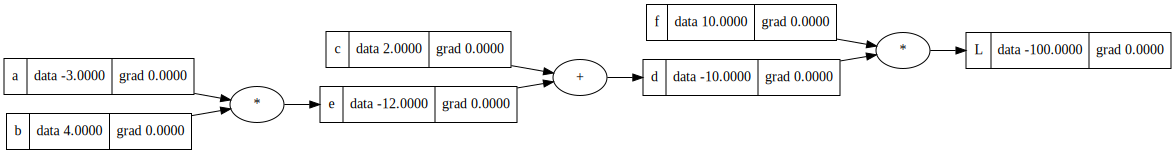

In [245]:
draw_dot(L)

In [247]:
L.grad=1
d.grad=10
f.grad=-10

In [249]:
def lol():
    h=0.0001
    a=Value(-3.0,label='a')
    b=Value(4.0,label='b')
    c=Value(2.0,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(10,label='f')
    L=d*f;L.label='L'
    L1=L.data

    a=Value(-3.0,label='a')
    b=Value(4.0,label='b')
    c=Value(2.0,label='c')
    b.data+=h
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(10,label='f')
    L=d*f;L.label='L'
    L2=L.data

    print((L2-L1)/h)
lol()

-29.99999999985903


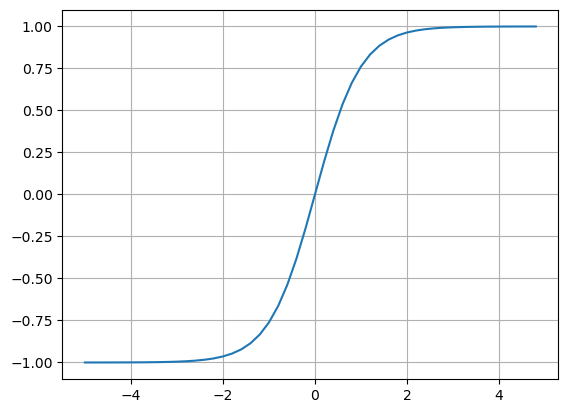

In [251]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [301]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label='o'

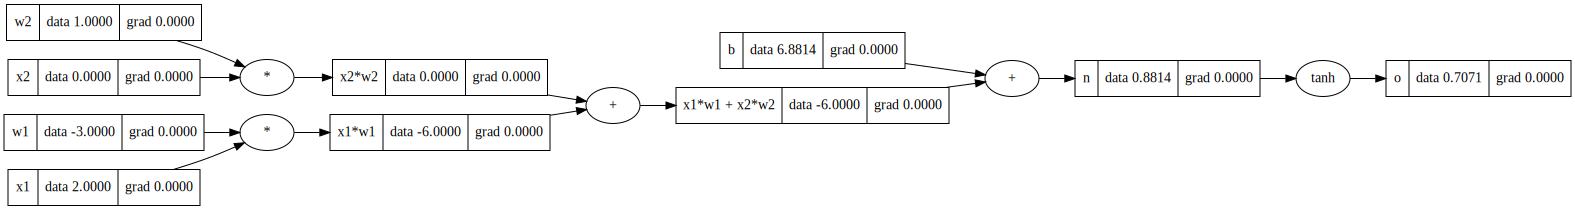

In [303]:
draw_dot(o)

In [275]:
o.grad=1.0

In [279]:
#o= tanh(n)
#do/dn=1-o**2
1-o.data**2

0.4999999999999999

In [281]:
n.grad=0.5

In [285]:
x1w1x2w2.grad=0.5
b.grad=0.5

In [289]:
x2w2.grad=0.5
x1w1.grad=0.5

In [297]:
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

x1.grad=w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad

### Using Backward function, (Back propogation)

In [11]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label='o'

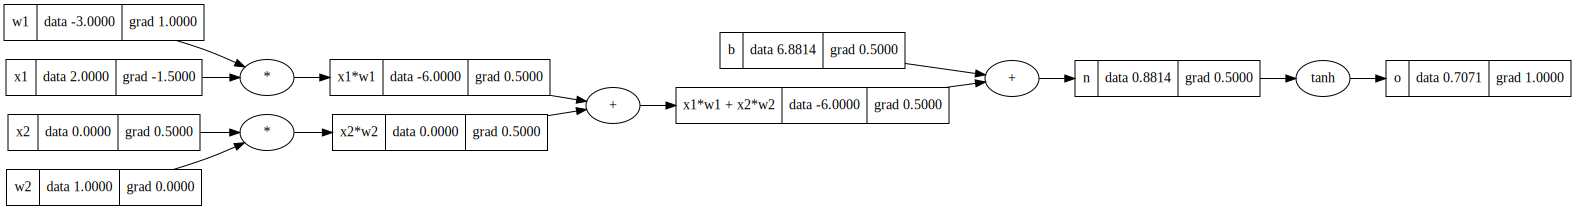

In [515]:
draw_dot(o)

In [491]:
o.grad=1.0

In [471]:
o._backward()

In [473]:
n._backward()

In [475]:
x1w1x2w2._backward()

In [477]:
b._backward()

In [479]:
x1w1._backward()

In [481]:
x2w2._backward()

### Using Topological Sort to Implement backward()

In [423]:
#you'll be in the list once all your children are in the list

In [13]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label='o'

In [15]:
o.grad=1.0

topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

### Implementing backward in Value class

In [18]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label='o'

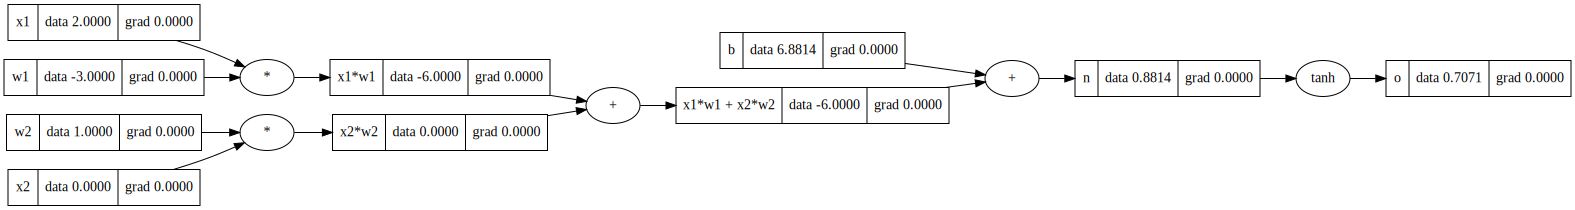

In [20]:
draw_dot(o)

In [540]:
o.backward()

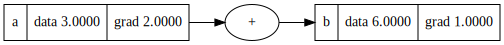

In [548]:
a=Value(3.0,label='a')
b=a+a;b.label='b'
b.backward()
draw_dot(b)

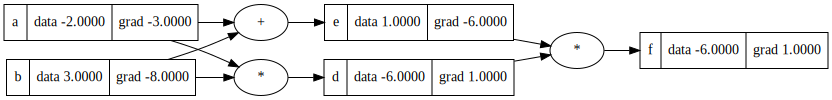

In [552]:
a=Value(-2.0,label='a')
b=Value(3.0,label='b')
d=a*b; d.label='d'
e=a+b; e.label='e'
f=d*e; f.label='f'

f.backward()
draw_dot(f)

### Implementing same thing in Pytorch

In [555]:
import torch

In [559]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Building a MLP for Micrograd

In [22]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    def parameters(self):
        return self.w+[self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.7177259979185577, grad=0.0)

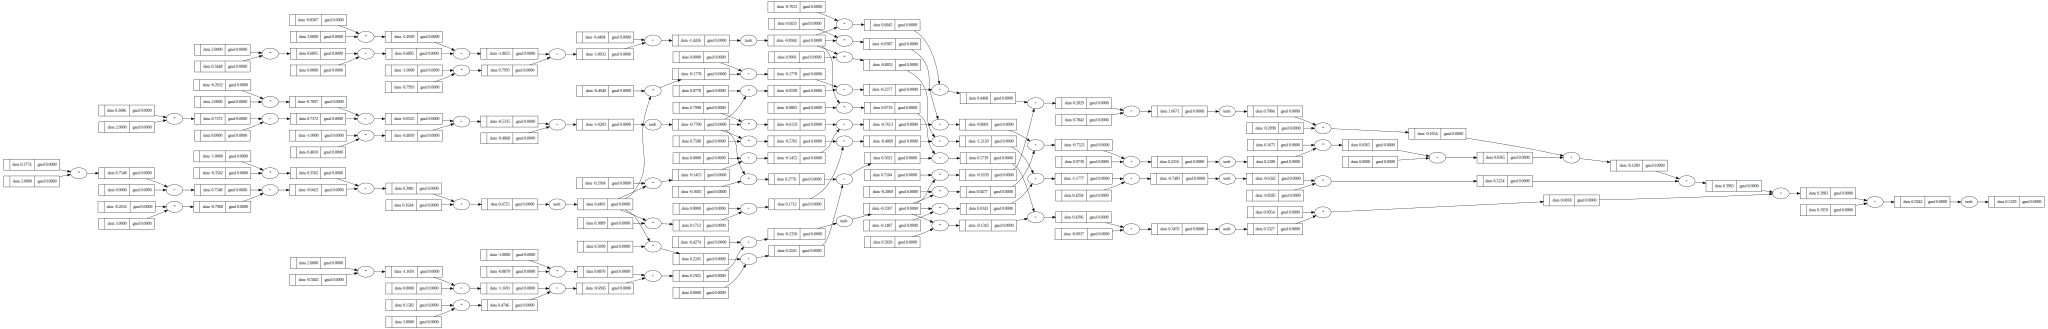

In [620]:
draw_dot(n(x))

# Writing a loss function

In [24]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

ypred = [n(x) for x in xs]
ypred


[Value(data=-0.7177259979185577, grad=0.0),
 Value(data=0.8564910689839953, grad=0.0),
 Value(data=-0.6360770815157892, grad=0.0),
 Value(data=-0.07095426225698961, grad=0.0)]

In [26]:
# finding mean squared error
loss =sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=7.676524615587121, grad=0.0)

In [28]:
loss.backward()

In [30]:
n.layers[0].neurons[0].w[0].grad

-1.25208016059718

In [32]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.6733436308612077, grad=0.0)

In [34]:
len(n.parameters())

41

In [118]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=6.002443992021233e-12, grad=0.0)

In [120]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=6.002443992021233e-12, grad=0.0)

In [122]:
loss.backward()

In [116]:
for p in n.parameters():
    p.data += -0.1 * p.grad

ypred

[Value(data=0.9999998983305688, grad=-2.0333886241452603e-07),
 Value(data=-0.99998637702729, grad=2.7245945420029116e-05),
 Value(data=-0.9999987394385781, grad=2.5211228438237754e-06),
 Value(data=0.9999999834546528, grad=-3.309069440682322e-08)]

### The data has converged to the answer by gradient descent

In [130]:
n.parameters()

[Value(data=-0.11728416931350359, grad=-0.30690842918766037),
 Value(data=1.9453876431018118, grad=-2.2340654060768923),
 Value(data=-4.060267279415031, grad=4.066254217935226),
 Value(data=-0.07395320009811329, grad=0.6597370919541061),
 Value(data=-0.7771638429837462, grad=0.4774413792005538),
 Value(data=0.9796939951101351, grad=-0.052904285508561064),
 Value(data=0.35858357181412615, grad=0.050133540428941),
 Value(data=0.38022270420030435, grad=0.18724613879061539),
 Value(data=0.09191378358671633, grad=0.6424064412914597),
 Value(data=-0.6975088629101189, grad=0.6336532190270385),
 Value(data=0.9188122428210791, grad=-0.9835101493508986),
 Value(data=0.05889479964929751, grad=0.3930764478156071),
 Value(data=-0.5258293370589447, grad=1.0305777367031033),
 Value(data=0.5890466631391664, grad=0.12807420902368716),
 Value(data=-2.3856398754035606, grad=3.0201588640393346),
 Value(data=-1.0802013926949035, grad=1.0988950997054499),
 Value(data=1.1266631338876287, grad=-0.649658414543

## Creating a gradient descent training loop

In [133]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.9999999912235601, grad=0.0),
 Value(data=-0.9999975616039604, grad=0.0),
 Value(data=-0.9999997621135592, grad=0.0),
 Value(data=0.999999998672862, grad=0.0)]

In [135]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.9527912993988888, grad=0.0)

In [145]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad=0.0
    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 7.092091373533808e-05
1 7.090092058066378e-05
2 7.088093867927905e-05
3 7.086096802169092e-05
4 7.084100859842054e-05
5 7.082106039999522e-05
6 7.080112341695765e-05
7 7.078119763985672e-05
8 7.076128305925534e-05
9 7.074137966572386e-05
10 7.07214874498467e-05
11 7.07016064022157e-05
12 7.068173651343676e-05
13 7.066187777412185e-05
14 7.064203017489827e-05
15 7.062219370639945e-05
16 7.060236835927144e-05
17 7.058255412417039e-05
18 7.056275099176507e-05
19 7.054295895273161e-05


In [149]:
ypred

[Value(data=0.9940614899141254, grad=-0.011877020171749297),
 Value(data=-0.9999915893277704, grad=1.6821344459128085e-05),
 Value(data=-0.9999922347019944, grad=1.5530596011226194e-05),
 Value(data=0.9940605618217346, grad=-0.011878876356530732)]

In [143]:
n.parameters()

[Value(data=1.0874514071062333, grad=-1.19972946413781),
 Value(data=0.1951937779108439, grad=0.42214826101666736),
 Value(data=0.8614629492669974, grad=-0.19619468243668517),
 Value(data=1.2257706564669333, grad=-0.37439704367250076),
 Value(data=-5.2186332466994365, grad=5.242890990094713),
 Value(data=0.6208343433145886, grad=-1.581918904769129),
 Value(data=-0.3531584221105079, grad=1.1918152582582286),
 Value(data=-1.8273765197360996, grad=1.8927754441639522),
 Value(data=-1.52325580641376, grad=1.9610750932057068),
 Value(data=-0.35455576935840266, grad=-0.8979796353953309),
 Value(data=-0.14709606231873684, grad=0.6291409232686412),
 Value(data=-1.0250193613932315, grad=0.5474243572889483),
 Value(data=-3.471853645723405, grad=21.60118476244026),
 Value(data=2.220978654507955, grad=-9.935939950644727),
 Value(data=-5.6181514251341325, grad=11.63689945733487),
 Value(data=-2.4211256650768274, grad=9.052264793970027),
 Value(data=0.880568684798221, grad=-7.690700423911107),
 Value